<a href="https://colab.research.google.com/github/FrancescaTorazzi/jellyfish_classification-/blob/main/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from d2l import torch as d2l

ModuleNotFoundError: No module named 'd2l'

In [23]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
zip_path = "/content/drive/MyDrive/JellyfishDataset/archive.zip"

In [ ]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [25]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/JellyfishDataset/archive.zip"  # <-- Verifica il percorso corretto
extract_path = "/content/dataset"  # Dove estrarre i file

# Estrazione dello ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File extracted in:", extract_path)


File extracted in: /content/dataset


In [26]:
print(os.listdir(extract_path))

['lions_mane_jellyfish', 'compass_jellyfish', 'mauve_stinger_jellyfish', 'Train_Test_Valid', 'Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish']


In [27]:
import shutil

# Percorso della cartella da eliminare
remove_path = os.path.join(extract_path, "Train_Test_Valid")

# Verifica se la cartella esiste ed eliminala
if os.path.exists(remove_path):
    shutil.rmtree(remove_path)
    print("Cartella 'Train_Test_Valid' rimossa con successo!")
else:
    print("La cartella 'Train_Test_Valid' non era presente.")

Cartella 'Train_Test_Valid' rimossa con successo!


In [28]:
from collections import Counter

# Conta i file in ogni sottocartella
data_dirs = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
file_counts = {d: len(os.listdir(os.path.join(extract_path, d))) for d in data_dirs}

print("Number of images for species:")
print(file_counts)

Number of images for species:
{'lions_mane_jellyfish': 150, 'compass_jellyfish': 150, 'mauve_stinger_jellyfish': 150, 'Moon_jellyfish': 150, 'barrel_jellyfish': 150, 'blue_jellyfish': 150}


liminazione della classe Train Test Valid

In [29]:
import zipfile
import os
import shutil



# Rimuovere la cartella 'Train_Test_Valid' se presente
folder_to_remove = os.path.join(extract_path, "Train_Test_Valid")
if os.path.exists(folder_to_remove):
    shutil.rmtree(folder_to_remove)
    print("Cartella 'Train_Test_Valid' rimossa con successo.")

# Verifica le classi dopo la rimozione
from torchvision import datasets
dataset = datasets.ImageFolder(extract_path)
print("Classi rimanenti:", dataset.classes)

Classi rimanenti: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


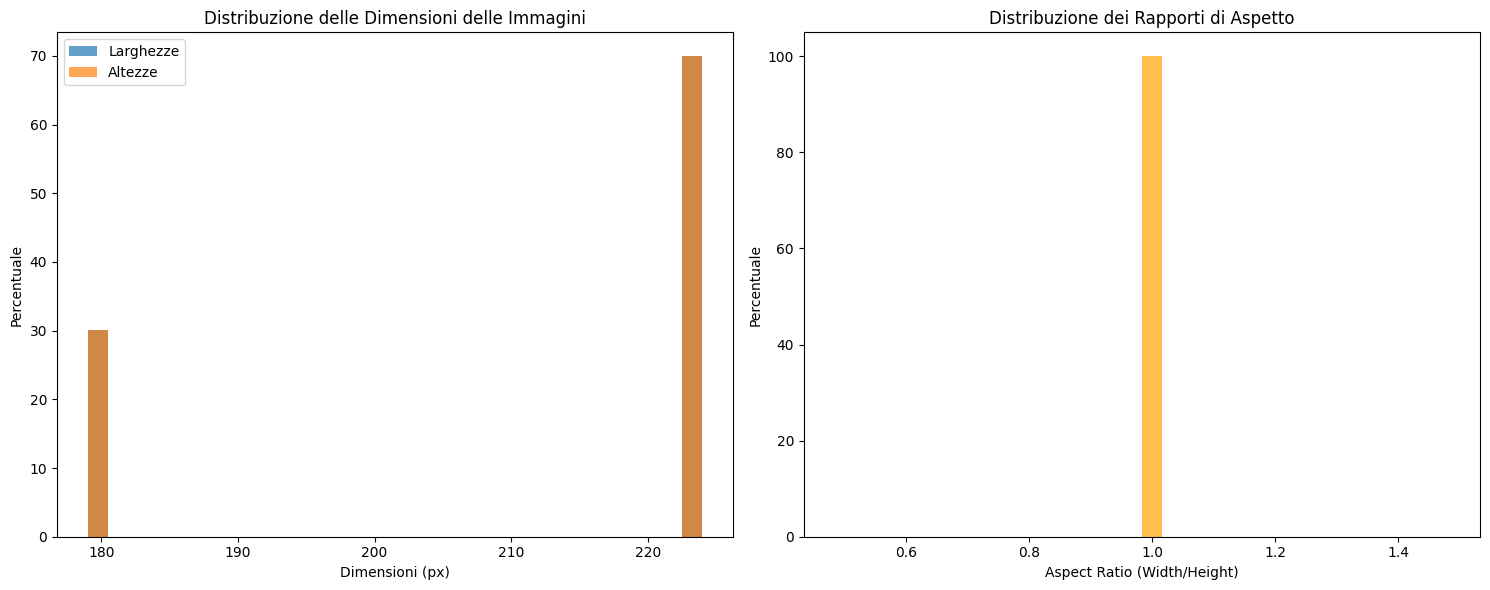

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Percorso del dataset
dataset_path = "/content/dataset"

# Lista per salvare le dimensioni delle immagini
image_sizes = []

# Scansiona tutte le immagini nelle cartelle del dataset
for root, _, files in os.walk(dataset_path):
    for image_name in files:
        if image_name.endswith(('.jpg', '.png', '.jpeg')):  # Controlla i formati immagine
            image_path = os.path.join(root, image_name)  # Percorso completo dell'immagine
            with Image.open(image_path) as img:
                image_sizes.append(img.size)  # (width, height)

# Estrai larghezze, altezze e aspect ratios
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]
aspect_ratios = [w / h for w, h in zip(widths, heights)]

# Distribuzione delle dimensioni (width, height)
width_counts, width_bins = np.histogram(widths, bins=30)
height_counts, height_bins = np.histogram(heights, bins=30)
width_percent = (width_counts / len(widths)) * 100
height_percent = (height_counts / len(heights)) * 100

# Distribuzione dei rapporti di aspetto
aspect_counts, aspect_bins = np.histogram(aspect_ratios, bins=30)
aspect_percent = (aspect_counts / len(aspect_ratios)) * 100

# Plot dei grafici
plt.figure(figsize=(15, 6))

# Plot 1: Distribuzione delle dimensioni (larghezza e altezza)
plt.subplot(1, 2, 1)
plt.bar(width_bins[:-1], width_percent, width=np.diff(width_bins)[0], alpha=0.7, label='Larghezze', align='edge')
plt.bar(height_bins[:-1], height_percent, width=np.diff(height_bins)[0], alpha=0.7, label='Altezze', align='edge')
plt.title('Distribuzione delle Dimensioni delle Immagini')
plt.xlabel('Dimensioni (px)')
plt.ylabel('Percentuale')
plt.legend()

# Plot 2: Distribuzione dei rapporti di aspetto
plt.subplot(1, 2, 2)
plt.bar(aspect_bins[:-1], aspect_percent, width=np.diff(aspect_bins)[0], alpha=0.7, color='orange')
plt.title('Distribuzione dei Rapporti di Aspetto')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Percentuale')

plt.tight_layout()
plt.show()


In [33]:
import shutil
import os

folder_to_remove = os.path.join(dataset_path, 'Train_Test_Valid')

if os.path.exists(folder_to_remove):
    shutil.rmtree(folder_to_remove)
    print(f"Cartella {folder_to_remove} eliminata definitivamente.")
else:
    print("Cartella già rimossa.")

Cartella /content/drive/MyDrive/JellyfishDataset/extracted/Train_Test_Valid eliminata definitivamente.


In [35]:
print("Classi trovate nel dataset:", os.listdir(dataset_path))

Classi trovate nel dataset: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


Il grafico mostra che la maggior parte delle immagini ha una larghezza di 180 px e un'altezza di 224 px, come evidenziato dai picchi nelle colonne corrispondenti. Ciò suggerisce che le immagini nel dataset sono prevalentemente rettangolari, con una larghezza inferiore rispetto all'altezza. Un aspetto interessante è che la distribuzione è molto concentrata su queste due dimensioni, indicando che il dataset potrebbe essere costituito principalmente da immagini con risoluzioni simili

The histogram represents the distribution of aspect ratios (width/height) in the dataset. Since all images have an aspect ratio of 1.0, this confirms that they are perfectly square (224x224). A uniform aspect ratio simplifies data augmentation and ensures consistency in convolutional neural networks

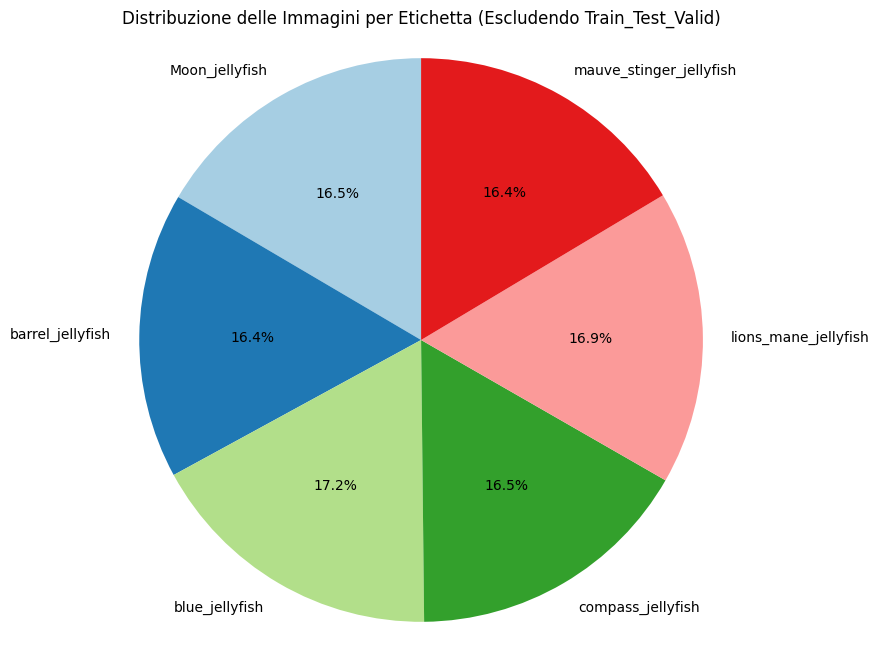

In [36]:
import os
import matplotlib.pyplot as plt

# Dizionario per contare le immagini per etichetta
label_counts = {}

# Traversiamo le sottocartelle per contare le immagini
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path) and label != 'Train_Test_Valid':  # Escludiamo 'Train_Test_Valid'
        num_images = len([file for file in os.listdir(label_path) if file.endswith(('.jpg', '.png', '.jpeg'))])
        label_counts[label] = num_images

# Verifica se ci sono etichette
if not label_counts:
    raise ValueError("No labels found in the dataset path.")

# Crea il grafico a torta
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Paired.colors)  # Usa colori diversi per una migliore distinzione
plt.title('Distribuzione delle Immagini per Etichetta (Escludendo Train_Test_Valid)')
plt.axis('equal')  # Per far sì che il grafico sia un cerchio
plt.show()


In [37]:
os.listdir(dataset_path)

['Moon_jellyfish',
 'barrel_jellyfish',
 'blue_jellyfish',
 'compass_jellyfish',
 'lions_mane_jellyfish',
 'mauve_stinger_jellyfish']

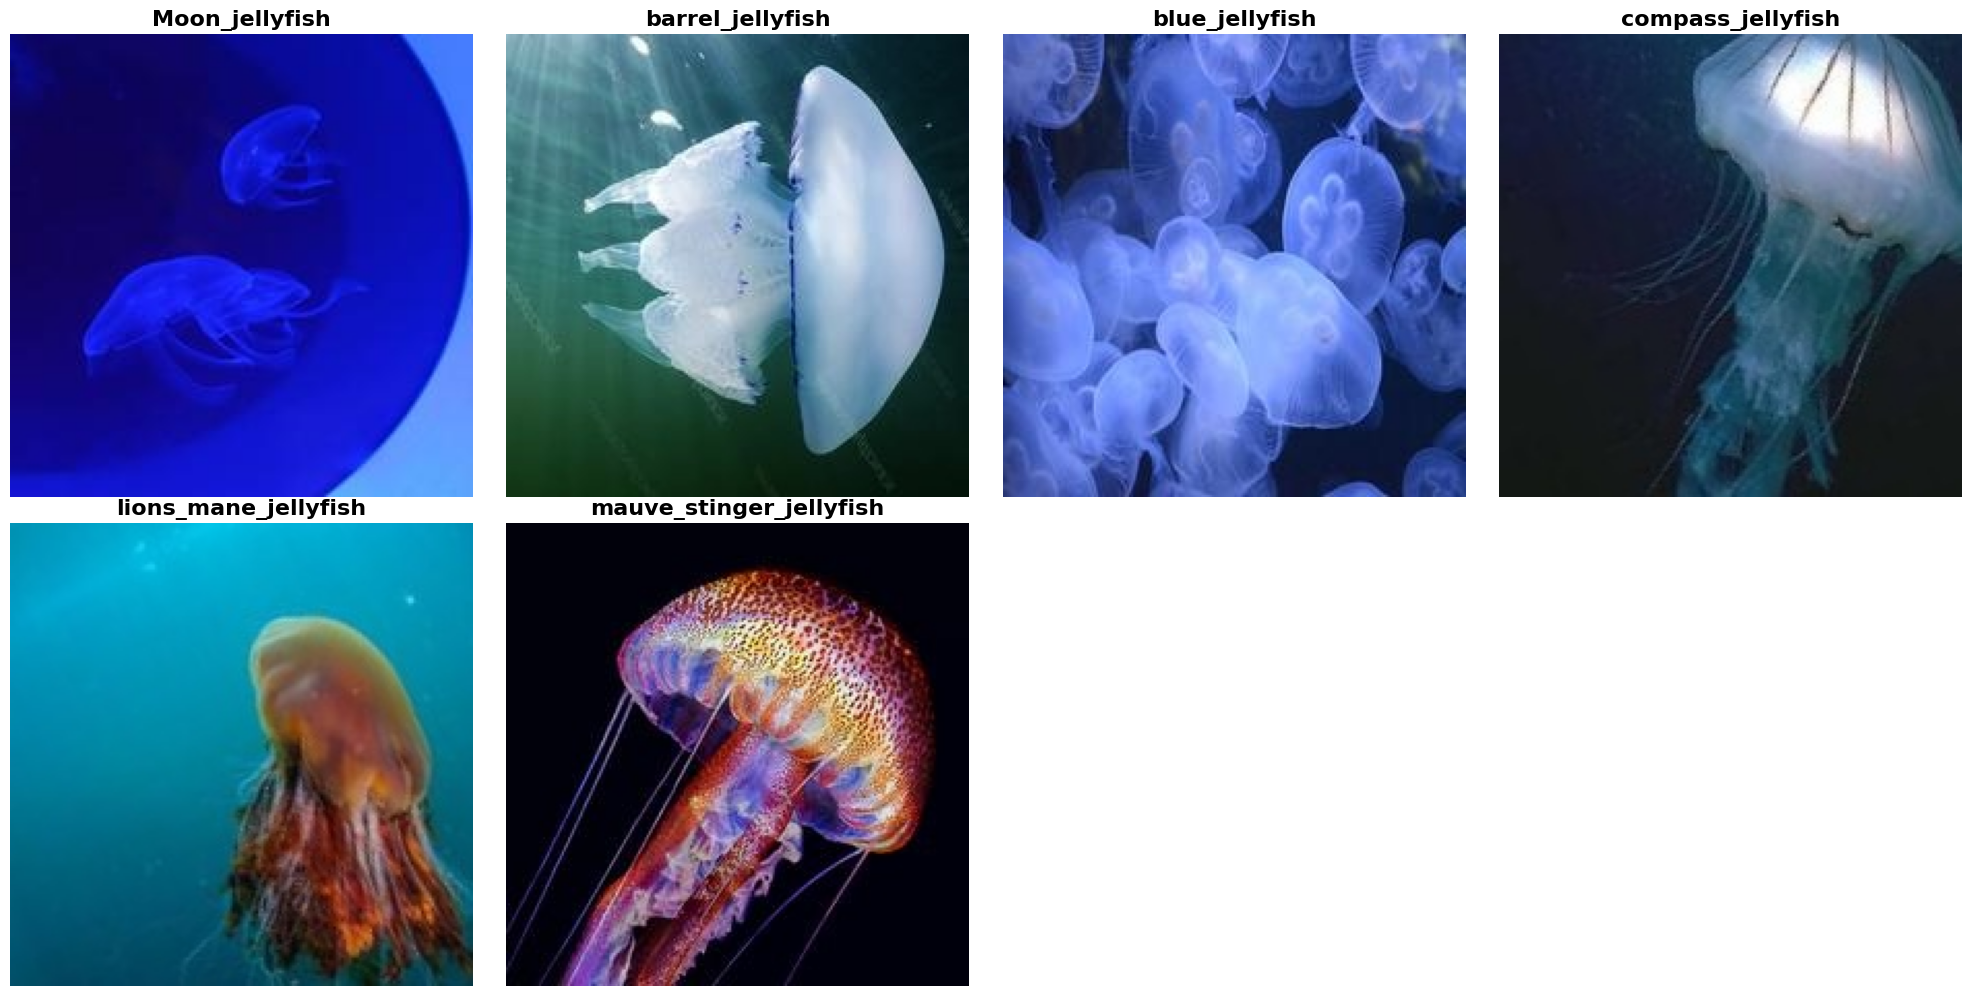

In [38]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Crea un dizionario con le immagini per ciascuna categoria (sottocartella)
category_to_images = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Verifica che sia una cartella
        category_to_images[label] = [file for file in os.listdir(label_path) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Verifica se ci sono categorie
if not category_to_images:
    raise ValueError("No categories found in the dataset path.")

# Imposta un seme per la riproducibilità
random.seed(123)

# Seleziona un'immagine casuale per ciascuna categoria
random_images = {}
for category, images in category_to_images.items():
    if images:  # Assicurati che ci siano immagini per la categoria
        random_images[category] = random.choice(images)

# Configura i plot
num_categories = len(random_images)
rows = (num_categories + 3) // 4  # Calcola dinamicamente il numero di righe per il grafico
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()

# Visualizza le immagini
for ax, (category, image_name) in zip(axes, random_images.items()):
    image_path = os.path.join(dataset_path, category, image_name)
    try:
        with Image.open(image_path) as img:
            ax.imshow(img)
            ax.set_title(category, fontsize=16, fontweight='bold')
            ax.axis('off')  # Nascondi gli assi per un aspetto più pulito
    except FileNotFoundError:
        ax.set_title(f"Missing: {category}", fontsize=16, fontweight='bold')
        ax.axis('off')  # Nascondi gli assi per le immagini mancanti

# Nascondi gli assi inutilizzati
for ax in axes[len(random_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Loading of the dataset**

Cosa si fa in questo blocco:

1. **Definisce la funzione `get_dataloader_workers()`**: Restituisce il numero di CPU per il caricamento parallelo dei dati.
2. **Definisce la funzione `data_loader()`**: Carica il dataset, applica trasformazioni, suddivide in training, validazione e test, e crea i DataLoader.
3. **Verifica normalizzazione**: Controlla se i parametri `mean` e `std` sono forniti per la normalizzazione.
4. **Trasformazioni di base**: Ridimensiona, converte in tensori e normalizza le immagini.
5. **Caricamento dataset con `ImageFolder()`**: Carica immagini e etichette basate sulla struttura delle sottocartelle.
6. **Suddivisione in training, validazione e test**: Usa `random_split()` per dividere il dataset.
7. **Augmentazione (opzionale)**: Applica trasformazioni di aumentazione solo al training set se richiesto.
8. **Creazione dei DataLoader**: Crea i DataLoader per il training, la validazione e il test, con parallelismo e batching.
9. **Ritorna i DataLoader**: Restituisce i DataLoader pronti per il training.

In [39]:
from torchvision import datasets, transforms
import torch
import numpy as np
from tqdm import tqdm


# Definisci la trasformazione per caricare le immagini (solo la conversione a tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini
    transforms.ToTensor()           # Converte le immagini in tensori
])

# Carica il dataset senza normalizzazione per calcolare la media e la deviazione standard
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Funzione per calcolare la media e la deviazione standard
def calculate_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = len(dataset)

    # Usa tqdm per un progresso visivo
    for img, _ in tqdm(dataset):
        mean += img.mean(dim=[1, 2])  # Calcola la media per ogni canale
        std += img.std(dim=[1, 2])    # Calcola la deviazione standard per ogni canale

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = calculate_mean_std(dataset)

print("Mean:", mean)
print("Std:", std)


100%|██████████| 900/900 [00:09<00:00, 94.72it/s] 


Mean: tensor([0.2614, 0.3639, 0.4199])
Std: tensor([0.1937, 0.1780, 0.1946])


In [40]:
#ricontrollo se ci sia train val test
import os

# Lista delle cartelle nel dataset
class_folders = os.listdir(dataset_path)

# Stampa le classi presenti
print("Classi trovate nel dataset:", class_folders)

Classi trovate nel dataset: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [41]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os
import torch


# Valori di mean e std calcolati per il tuo dataset
mean = [0.2614, 0.3639, 0.4199] # esempio di mean, sostituisci con i tuoi calcoli
std = [0.1937, 0.1780, 0.1946]   # esempio di std, sostituisci con i tuoi calcoli

# Funzione per ottenere il numero di worker per il DataLoader
def get_dataloader_workers():
    import os
    return os.cpu_count()

# Funzione per caricare il dataset e creare i DataLoader
def data_loader(dataset_path,
                batch_size,
                height, width,
                augmentation=False,
                train_perc=0.7, val_perc=0.2,
                seed=123,
                mean=None, std=None):

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Verifica che mean e std siano forniti
    if mean is None or std is None:
        raise ValueError("Mean and Std must be provided for normalization.")

    # Trasformazioni di base (resize, tensorizzazione e normalizzazione)
    trans = transforms.Compose([
        transforms.Resize((height, width)),  # Ridimensiona a (height, width)
        transforms.ToTensor(),               # Converte in tensore
        transforms.Normalize(mean=mean, std=std)  # Normalizzazione
    ])

    # Carica il dataset con ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=trans)

    # Calcola la dimensione del dataset
    dataset_size = len(dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Divisione del dataset in training, validation e test
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Se l'augmentation è abilitata, applica solo al training set
    if augmentation:
        data_augmentation = transforms.Compose([
            transforms.Resize((height, width)),  # Ridimensiona a (height, width)

            # Data Augmentation
            transforms.RandomApply([transforms.RandomRotation(degrees=20)], p=0.5),
            transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.5),
            transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.5),
            transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),

            transforms.ToTensor(),  # Converte in tensore
            transforms.Normalize(mean=mean, std=std)  # Normalizzazione
        ])

        train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=data_augmentation)

    # Creazione dei DataLoader per training, validation e test
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return dataset, train_loader, val_loader, test_loader


# Esegui il caricamento del dataset con il batch_size, height, width e mean/std
dataset, train_loader, val_loader, test_loader = data_loader(
    dataset_path=dataset_path,
    batch_size=64,
    height=224,
    width=224,
    augmentation=True,
    mean=mean,
    std=std
)

# Mostra la dimensione dei set di dati per confermare la divisione
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Train set size: 630
Validation set size: 180
Test set size: 90


**Visualization of a batch**

Train set size: 630
Validation set size: 180
Test set size: 90


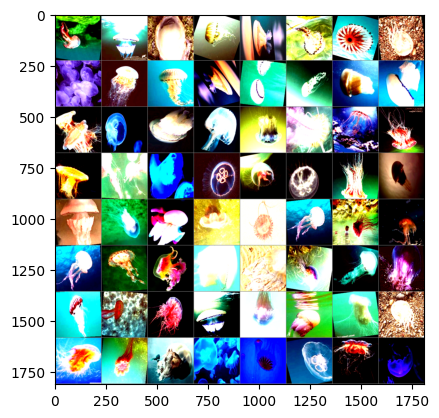

In [42]:
# Mostra la dimensione dei set di dati per confermare la divisione
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

# Visualizza alcune immagini casuali dal training set per verificarne la qualità
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Funzione per visualizzare un batch di immagini
def imshow(img):
    img = img / 2 + 0.5  # De-normalizza l'immagine
    npimg = img.numpy()  # Converte il tensore in array numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Cambia l'ordine degli assi per visualizzare l'immagine
    plt.show()

# Estrai un batch dal DataLoader del training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostra il batch di immagini
imshow(make_grid(images))


**Inceptions**

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()

        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        # Path 2: 1x1 -> 3x3 Convolution
        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
        )

        # Path 3: 1x1 -> 5x5 Convolution
        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
        )

        # Path 4: Max Pooling -> 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
        )

    def forward(self, x):
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        output = torch.cat((p1, p2, p3, p4), dim=1)
        return output


**Blocks GoogLeNet**

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definizione del modulo Inception
class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()

        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
        )

        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
        )

        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
        )

    def forward(self, x):
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        output = torch.cat((p1, p2, p3, p4), dim=1)
        return output

# Blocco 1
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.1)
)

# Blocco 2
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.BatchNorm2d(192),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.2)
)

# Blocco 3
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Blocco 4
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Blocco 5
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Dropout(p=0.4)
)

# Rete completa
num_classes = 6  # Cambia in base al numero di classi nel dataset
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, num_classes)
)

# Stampa la struttura del modello
print(net)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Inception(
      (path1): Sequential(
        (0): Conv2d(192, 64, kern

The code below tests the forward pass through the layers of the network by feeding a randomly generated input tensor 𝑋 of shape (1, 3, 224, 224), which simulates a single RGB image resized to 224×224 pixels.

Purpose: The loop iterates over each layer of the network (net), processes the input through the layer, and prints the layer's class name along with the shape of its output.

It helps verify how the spatial dimensions and channel sizes evolve as the data flows through the network. Useful for debugging or ensuring the network architecture behaves as expected.

In [45]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape' ,X.shape)

Sequential output shape torch.Size([1, 64, 56, 56])
Sequential output shape torch.Size([1, 192, 28, 28])
Sequential output shape torch.Size([1, 480, 14, 14])
Sequential output shape torch.Size([1, 832, 7, 7])
Sequential output shape torch.Size([1, 1024])
Linear output shape torch.Size([1, 6])


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def accuracy(y_hat, y):
    """Calcola l'accuratezza delle predizioni."""
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean().item()

def train(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4, device=None):
    """
    Allena un modello con GPU (se disponibile).
    """

    # Se il device non è specificato, prova a usare la GPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Xavier initialization
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f'Training on {device}')

    net.to(device)  # Sposta il modello su GPU (se disponibile)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        net.train()
        epoch_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(1) == y).sum().item()
            total += X.size(0)

            progress_bar.set_postfix(loss=epoch_loss / total, acc=correct / total)

        # Validazione dopo ogni epoca
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(1) == y).sum().item()
                val_total += X.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: Train Loss={epoch_loss/total:.4f}, Train Acc={correct/total:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Salvataggio del modello finale
    torch.save(net.state_dict(), 'Jellyfish_Inception.pth')
    print("Modello finale salvato come 'Jellyfish_Inception.pth'")

    return net


In [49]:
train(net, train_loader, val_loader, test_loader, num_epochs=50, lr=0.01)

Training on cpu


Epoch 1/50: 100%|██████████| 10/10 [04:11<00:00, 25.17s/it, acc=0.19, loss=2.46]


Epoch 1: Train Loss=2.4618, Train Acc=0.1905, Val Loss=1.7998, Val Acc=0.1722


Epoch 2/50: 100%|██████████| 10/10 [04:11<00:00, 25.20s/it, acc=0.248, loss=1.95]


Epoch 2: Train Loss=1.9535, Train Acc=0.2476, Val Loss=1.7512, Val Acc=0.2333


Epoch 3/50: 100%|██████████| 10/10 [04:02<00:00, 24.30s/it, acc=0.311, loss=1.74]


Epoch 3: Train Loss=1.7402, Train Acc=0.3111, Val Loss=2.2929, Val Acc=0.3444


Epoch 4/50: 100%|██████████| 10/10 [04:00<00:00, 24.02s/it, acc=0.356, loss=1.53]


Epoch 4: Train Loss=1.5305, Train Acc=0.3556, Val Loss=2.0752, Val Acc=0.3722


Epoch 5/50: 100%|██████████| 10/10 [04:00<00:00, 24.07s/it, acc=0.375, loss=1.53]


Epoch 5: Train Loss=1.5277, Train Acc=0.3746, Val Loss=1.6646, Val Acc=0.3444


Epoch 6/50: 100%|██████████| 10/10 [04:02<00:00, 24.26s/it, acc=0.392, loss=1.55]


Epoch 6: Train Loss=1.5539, Train Acc=0.3921, Val Loss=1.5417, Val Acc=0.4111


Epoch 7/50: 100%|██████████| 10/10 [04:02<00:00, 24.23s/it, acc=0.376, loss=1.53]


Epoch 7: Train Loss=1.5314, Train Acc=0.3762, Val Loss=1.5317, Val Acc=0.3222


Epoch 8/50: 100%|██████████| 10/10 [04:00<00:00, 24.08s/it, acc=0.395, loss=1.49]


Epoch 8: Train Loss=1.4870, Train Acc=0.3952, Val Loss=1.4924, Val Acc=0.4333


Epoch 9/50: 100%|██████████| 10/10 [04:00<00:00, 24.03s/it, acc=0.43, loss=1.46]


Epoch 9: Train Loss=1.4572, Train Acc=0.4302, Val Loss=1.5068, Val Acc=0.3833


Epoch 10/50: 100%|██████████| 10/10 [04:01<00:00, 24.18s/it, acc=0.422, loss=1.46]


Epoch 10: Train Loss=1.4559, Train Acc=0.4222, Val Loss=1.6391, Val Acc=0.3556


Epoch 11/50: 100%|██████████| 10/10 [04:01<00:00, 24.13s/it, acc=0.444, loss=1.44]


Epoch 11: Train Loss=1.4364, Train Acc=0.4444, Val Loss=1.6197, Val Acc=0.2611


Epoch 12/50: 100%|██████████| 10/10 [04:01<00:00, 24.14s/it, acc=0.429, loss=1.52]


Epoch 12: Train Loss=1.5250, Train Acc=0.4286, Val Loss=1.6680, Val Acc=0.4056


Epoch 13/50: 100%|██████████| 10/10 [03:59<00:00, 23.93s/it, acc=0.465, loss=1.41]


Epoch 13: Train Loss=1.4145, Train Acc=0.4651, Val Loss=1.5405, Val Acc=0.3278


Epoch 14/50: 100%|██████████| 10/10 [04:02<00:00, 24.23s/it, acc=0.475, loss=1.41]


Epoch 14: Train Loss=1.4116, Train Acc=0.4746, Val Loss=1.4586, Val Acc=0.3722


Epoch 15/50: 100%|██████████| 10/10 [03:59<00:00, 23.94s/it, acc=0.448, loss=1.4]


Epoch 15: Train Loss=1.4004, Train Acc=0.4476, Val Loss=1.4840, Val Acc=0.3778


Epoch 16/50: 100%|██████████| 10/10 [04:03<00:00, 24.34s/it, acc=0.476, loss=1.34]


Epoch 16: Train Loss=1.3358, Train Acc=0.4762, Val Loss=1.4453, Val Acc=0.3722


Epoch 17/50: 100%|██████████| 10/10 [04:06<00:00, 24.66s/it, acc=0.479, loss=1.34]


Epoch 17: Train Loss=1.3371, Train Acc=0.4794, Val Loss=1.3907, Val Acc=0.4500


Epoch 18/50: 100%|██████████| 10/10 [04:07<00:00, 24.75s/it, acc=0.457, loss=1.29]


Epoch 18: Train Loss=1.2900, Train Acc=0.4571, Val Loss=1.5203, Val Acc=0.3833


Epoch 19/50: 100%|██████████| 10/10 [04:01<00:00, 24.19s/it, acc=0.473, loss=1.33]


Epoch 19: Train Loss=1.3288, Train Acc=0.4730, Val Loss=1.4767, Val Acc=0.3500


Epoch 20/50: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, acc=0.487, loss=1.27]


Epoch 20: Train Loss=1.2742, Train Acc=0.4873, Val Loss=1.4912, Val Acc=0.4278


Epoch 21/50: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, acc=0.498, loss=1.26]


Epoch 21: Train Loss=1.2560, Train Acc=0.4984, Val Loss=1.3953, Val Acc=0.4389


Epoch 22/50: 100%|██████████| 10/10 [03:58<00:00, 23.89s/it, acc=0.508, loss=1.21]


Epoch 22: Train Loss=1.2125, Train Acc=0.5079, Val Loss=1.6024, Val Acc=0.3000


Epoch 23/50: 100%|██████████| 10/10 [03:59<00:00, 23.98s/it, acc=0.532, loss=1.24]


Epoch 23: Train Loss=1.2444, Train Acc=0.5317, Val Loss=1.5481, Val Acc=0.3889


Epoch 24/50: 100%|██████████| 10/10 [04:04<00:00, 24.47s/it, acc=0.537, loss=1.2]


Epoch 24: Train Loss=1.1975, Train Acc=0.5365, Val Loss=1.5123, Val Acc=0.3333


Epoch 25/50: 100%|██████████| 10/10 [04:04<00:00, 24.41s/it, acc=0.568, loss=1.16]


Epoch 25: Train Loss=1.1643, Train Acc=0.5683, Val Loss=1.4094, Val Acc=0.4389


Epoch 26/50: 100%|██████████| 10/10 [04:02<00:00, 24.24s/it, acc=0.549, loss=1.19]


Epoch 26: Train Loss=1.1883, Train Acc=0.5492, Val Loss=1.3271, Val Acc=0.4667


Epoch 27/50: 100%|██████████| 10/10 [04:04<00:00, 24.49s/it, acc=0.57, loss=1.11]


Epoch 27: Train Loss=1.1101, Train Acc=0.5698, Val Loss=1.3086, Val Acc=0.4833


Epoch 28/50: 100%|██████████| 10/10 [04:03<00:00, 24.33s/it, acc=0.57, loss=1.14]


Epoch 28: Train Loss=1.1389, Train Acc=0.5698, Val Loss=1.2819, Val Acc=0.4944


Epoch 29/50: 100%|██████████| 10/10 [03:59<00:00, 23.93s/it, acc=0.573, loss=1.12]


Epoch 29: Train Loss=1.1156, Train Acc=0.5730, Val Loss=1.5311, Val Acc=0.3778


Epoch 30/50: 100%|██████████| 10/10 [04:02<00:00, 24.21s/it, acc=0.563, loss=1.1]


Epoch 30: Train Loss=1.0951, Train Acc=0.5635, Val Loss=1.5899, Val Acc=0.4111


Epoch 31/50: 100%|██████████| 10/10 [04:08<00:00, 24.81s/it, acc=0.556, loss=1.2]


Epoch 31: Train Loss=1.1998, Train Acc=0.5556, Val Loss=1.8277, Val Acc=0.4167


Epoch 32/50: 100%|██████████| 10/10 [03:59<00:00, 23.90s/it, acc=0.549, loss=1.22]


Epoch 32: Train Loss=1.2151, Train Acc=0.5492, Val Loss=1.3522, Val Acc=0.4444


Epoch 33/50: 100%|██████████| 10/10 [04:04<00:00, 24.41s/it, acc=0.563, loss=1.14]


Epoch 33: Train Loss=1.1409, Train Acc=0.5635, Val Loss=1.2802, Val Acc=0.4944


Epoch 34/50: 100%|██████████| 10/10 [03:59<00:00, 23.97s/it, acc=0.605, loss=1.04]


Epoch 34: Train Loss=1.0398, Train Acc=0.6048, Val Loss=1.6754, Val Acc=0.3056


Epoch 35/50: 100%|██████████| 10/10 [04:01<00:00, 24.17s/it, acc=0.656, loss=0.99]


Epoch 35: Train Loss=0.9897, Train Acc=0.6556, Val Loss=1.5479, Val Acc=0.3278


Epoch 36/50: 100%|██████████| 10/10 [04:00<00:00, 24.07s/it, acc=0.571, loss=1.15]


Epoch 36: Train Loss=1.1492, Train Acc=0.5714, Val Loss=1.4164, Val Acc=0.3833


Epoch 37/50: 100%|██████████| 10/10 [04:00<00:00, 24.06s/it, acc=0.602, loss=1.06]


Epoch 37: Train Loss=1.0595, Train Acc=0.6016, Val Loss=1.3745, Val Acc=0.4222


Epoch 38/50: 100%|██████████| 10/10 [04:00<00:00, 24.05s/it, acc=0.63, loss=1.02]


Epoch 38: Train Loss=1.0248, Train Acc=0.6302, Val Loss=1.5995, Val Acc=0.4389


Epoch 39/50: 100%|██████████| 10/10 [04:09<00:00, 24.91s/it, acc=0.622, loss=1.02]


Epoch 39: Train Loss=1.0225, Train Acc=0.6222, Val Loss=1.7598, Val Acc=0.3278


Epoch 40/50: 100%|██████████| 10/10 [04:00<00:00, 24.06s/it, acc=0.638, loss=0.988]


Epoch 40: Train Loss=0.9878, Train Acc=0.6381, Val Loss=1.4323, Val Acc=0.4389


Epoch 41/50: 100%|██████████| 10/10 [03:59<00:00, 23.97s/it, acc=0.617, loss=1.06]


Epoch 41: Train Loss=1.0577, Train Acc=0.6175, Val Loss=1.8828, Val Acc=0.4111


Epoch 42/50: 100%|██████████| 10/10 [03:59<00:00, 23.97s/it, acc=0.59, loss=1.02]


Epoch 42: Train Loss=1.0176, Train Acc=0.5905, Val Loss=1.4284, Val Acc=0.4056


Epoch 43/50: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, acc=0.568, loss=1.09]


Epoch 43: Train Loss=1.0854, Train Acc=0.5683, Val Loss=1.5331, Val Acc=0.3778


Epoch 44/50: 100%|██████████| 10/10 [04:01<00:00, 24.14s/it, acc=0.641, loss=0.991]


Epoch 44: Train Loss=0.9911, Train Acc=0.6413, Val Loss=2.0671, Val Acc=0.2889


Epoch 45/50: 100%|██████████| 10/10 [03:59<00:00, 23.94s/it, acc=0.617, loss=1.05]


Epoch 45: Train Loss=1.0456, Train Acc=0.6175, Val Loss=1.5131, Val Acc=0.3556


Epoch 46/50: 100%|██████████| 10/10 [04:07<00:00, 24.77s/it, acc=0.659, loss=0.974]


Epoch 46: Train Loss=0.9744, Train Acc=0.6587, Val Loss=1.4177, Val Acc=0.4389


Epoch 47/50: 100%|██████████| 10/10 [04:00<00:00, 24.08s/it, acc=0.66, loss=0.967]


Epoch 47: Train Loss=0.9667, Train Acc=0.6603, Val Loss=1.6953, Val Acc=0.4167


Epoch 48/50: 100%|██████████| 10/10 [04:00<00:00, 24.00s/it, acc=0.665, loss=0.919]


Epoch 48: Train Loss=0.9192, Train Acc=0.6651, Val Loss=1.7262, Val Acc=0.2944


Epoch 49/50: 100%|██████████| 10/10 [04:06<00:00, 24.66s/it, acc=0.64, loss=0.974]


Epoch 49: Train Loss=0.9738, Train Acc=0.6397, Val Loss=1.5212, Val Acc=0.4056


Epoch 50/50: 100%|██████████| 10/10 [04:03<00:00, 24.31s/it, acc=0.649, loss=0.974]


Epoch 50: Train Loss=0.9737, Train Acc=0.6492, Val Loss=1.4065, Val Acc=0.4833
Modello finale salvato come 'Jellyfish_Inception.pth'


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Inception(
      (path1): Sequential(
        (0): Conv2d(192, 64, kern

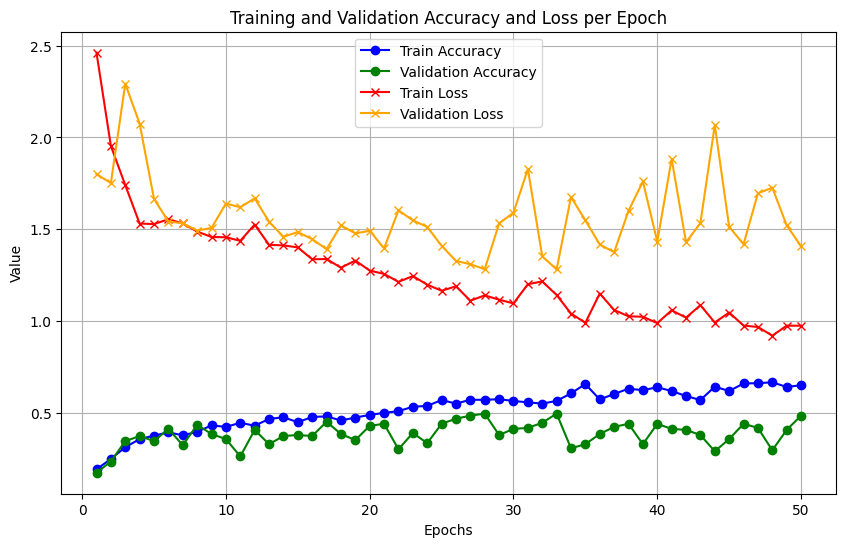

In [52]:
import matplotlib.pyplot as plt

# I dati dell'accuratezza e della perdita per ogni epoca
epochs = list(range(1, 51))
train_acc = [0.1905, 0.2476, 0.3111, 0.3556, 0.3746, 0.3921, 0.3762, 0.3952, 0.4302, 0.4222, 0.4444, 0.4286,
             0.4651, 0.4746, 0.4476, 0.4762, 0.4794, 0.4571, 0.4730, 0.4873, 0.4984, 0.5079, 0.5317, 0.5365, 0.5683,
             0.5492, 0.5698, 0.5698, 0.5730, 0.5635, 0.5556, 0.5492, 0.5635, 0.6048, 0.6556, 0.5714, 0.6016, 0.6302,
             0.6222, 0.6381, 0.6175, 0.5905, 0.5683, 0.6413, 0.6175, 0.6587, 0.6603, 0.6651, 0.6397, 0.6492]
val_acc = [0.1722, 0.2333, 0.3444, 0.3722, 0.3444, 0.4111, 0.3222, 0.4333, 0.3833, 0.3556, 0.2611, 0.4056, 0.3278,
           0.3722, 0.3778, 0.3722, 0.4500, 0.3833, 0.3500, 0.4278, 0.4389, 0.3000, 0.3889, 0.3333, 0.4389, 0.4667,
           0.4833, 0.4944, 0.3778, 0.4111, 0.4167, 0.4444, 0.4944, 0.3056, 0.3278, 0.3833, 0.4222, 0.4389, 0.3278,
           0.4389, 0.4111, 0.4056, 0.3778, 0.2889, 0.3556, 0.4389, 0.4167, 0.2944, 0.4056, 0.4833]

train_loss = [2.4618, 1.9535, 1.7402, 1.5305, 1.5277, 1.5539, 1.5314, 1.4870, 1.4572, 1.4559, 1.4364, 1.5250, 1.4145,
              1.4116, 1.4004, 1.3358, 1.3371, 1.2900, 1.3288, 1.2742, 1.2560, 1.2125, 1.2444, 1.1975, 1.1643, 1.1883,
              1.1101, 1.1389, 1.1156, 1.0951, 1.1998, 1.2151, 1.1409, 1.0398, 0.9897, 1.1492, 1.0595, 1.0248, 1.0225,
              0.9878, 1.0577, 1.0176, 1.0854, 0.9911, 1.0456, 0.9744, 0.9667, 0.9192, 0.9738, 0.9737]
val_loss = [1.7998, 1.7512, 2.2929, 2.0752, 1.6646, 1.5417, 1.5317, 1.4924, 1.5068, 1.6391, 1.6197, 1.6680, 1.5405,
            1.4586, 1.4840, 1.4453, 1.3907, 1.5203, 1.4767, 1.4912, 1.3953, 1.6024, 1.5481, 1.5123, 1.4094, 1.3271,
            1.3086, 1.2819, 1.5311, 1.5899, 1.8277, 1.3522, 1.2802, 1.6754, 1.5479, 1.4164, 1.3745, 1.5995, 1.7598,
            1.4323, 1.8828, 1.4284, 1.5331, 2.0671, 1.5131, 1.4177, 1.6953, 1.7262, 1.5212, 1.4065]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', linestyle='-', marker='o')
plt.plot(epochs, train_loss, label='Train Loss', color='red', linestyle='-', marker='x')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='-', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Accuracy and Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

